### Snorkel LLM Validation Experiment - Llama 3 8B
In previous experiments, we have tried various labeling functions that use text embedding models to compute semantic similarity scores between the definition of a field and the abstract of a paper. Those experiments yielded low scores across the board, which points to either: 1) bad definitions, 2) too high of a threshold, 3) semantic similarity being a bad approach.

Results from that experiment seem to hint either 1 or 3. In this experiment, we will look into other approaches, namely the use of prompting an LLM to produce a label instead of semantic similarity. We use [Meta Llama 3](https://ai.meta.com/blog/meta-llama-3/), the most capable open source model available (8B parameters model). We use the [Ollama](https://ollama.com/) Python package to integrate it in Python.

In [1]:
import pandas as pd
import ollama    

In [4]:
df = pd.read_csv("data/text-classification-train.csv")
df.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [8]:
df_labeled = pd.DataFrame()
df_labeled["abstract"] = df["ABSTRACT"][:200]
df_labeled["CS_actual"] = df["Computer Science"][:200]
df_labeled

,abstract,CS_actual
0,Predictive models allow subject-specific inf...,1
1,Rotation invariance and translation invarian...,1
2,We introduce and develop the notion of spher...,0
3,The stochastic Landau--Lifshitz--Gilbert (LL...,0
4,Fourier-transform infra-red (FTIR) spectra o...,1
...,...,...
195,We relate the concepts used in decentralized...,0
196,Time-varying network topologies can deeply i...,1
197,A long-standing obstacle to progress in deep...,1
198,We study the band structure topology and eng...,0


In [9]:
def label_abstract(x):
    prompt = f'''After the next two sentences, I will paste an abstract from a research article. I want you
        to respond "1" if the abstract comes from a paper in the computer science field, and "0"
        if it doesn't, or if you are not sure. Do not include anything else in your response; just
        the number. Please classify this abstract: {x}'''
    response = ollama.chat(model='llama3', messages=[
      {
        'role': 'user',
        'content': prompt,
      },
    ])
    return int(response['message']['content'])

In [17]:
# Chunk 1
df_labeled['Llama3_CS'][:50] = df_labeled['abstract'][:50].apply(label_abstract)

C:\Users\arnav\AppData\Local\Temp\ipykernel_30896\1228611457.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labeled['Llama3_CS'][:50] = df_labeled['abstract'][:50].apply(label_abstract)
C:\Users\arnav\AppData\Local\Temp\ipykernel_30896\1228611457.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['1' '1' '1' '0' '1' '1' '0' '1' '1' '0' '0' '0' '0' '1' '0' '1' '0' '1'
 '1' '1' '0' '0' '1' '1' '0' '1' '1' '1' '1' '1' '1' '0' '1' '1' '1' '1'
 '1' '1' '0' '1' '1' '0' '1' '1' '1' '1' '0' '1' '1' '1']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_labeled['Llama3_CS'][:50] = df_labeled['abstract'][:50].apply(label_abstract)


In [20]:
# Chunk 2
df_labeled['Llama3_CS'][50:100] = df_labeled['abstract'][50:100].apply(label_abstract)

In [27]:
# Chunk 3
df_labeled['Llama3_CS'][100:150] = df_labeled['abstract'][100:150].apply(label_abstract)

In [31]:
# Chunk 4
df_labeled['Llama3_CS'][150:200] = df_labeled['abstract'][150:200].apply(label_abstract)

In [46]:
df_labeled['Llama3_CS'] = pd.to_numeric(df_labeled['Llama3_CS'], errors='coerce')

### Evaluating Llama 3

In [35]:
# Number of actual CS documents
len(df_labeled[df_labeled['CS_actual'] == 1])

78

In [49]:
llama3_accuracy = len(df_labeled[df_labeled['CS_actual'] == df_labeled['Llama3_CS']]) / len(df_labeled)
llama3_accuracy

0.68

<Axes: >

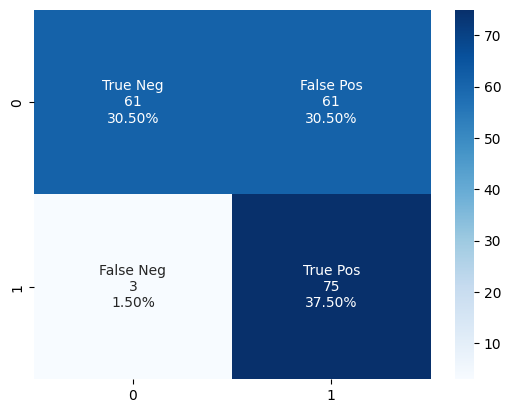

In [71]:
# Source: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea

from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

cm = confusion_matrix(df_labeled['CS_actual'], df_labeled['Llama3_CS'])

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cm, annot=labels, fmt="", cmap='Blues')

The biggest error committed by this model is type 1 error: it labels many articles as CS even when they aren't CS articles. It is much more unlikely to label articles as non-CS when they are CS, which is why the false negative percentage is so low.

Let's take a look at four key metrics for classification models: recall, precision, accuracy, and F1-score

In [80]:
tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]

# Accuracy: the percent of correctly classified data
accuracy = (tn+tp)/(tn+fp+fn+tp)
accuracy

0.68

In [82]:
# Precision: positive predictive value; of those predicted as CS documents, how many were actually CS documents?
precision = (tp)/(tp+fp)
precision

0.5514705882352942

In [84]:
# Recall: of those that were actually CS documents, how many were predicted as CS documents?
recall = (tp)/(tp+fn)
recall

0.9615384615384616

In [86]:
# F1 score: tries to balance precision and recall, with uneven class distribution (large number of actual negs)
f1 = 2*((precision*recall)/(precision+recall))
f1

0.7009345794392524

For our circumstances, it seems more important that our recall is high than precision. This seems especially clear because the climate hazards we use will probably be more specific than broad CS, which would increase precision. However, if our model fails at recall, that seems bad.  

To that end, this indicates that the model is somewhat successful, since it has an insanely high recall rate. The model likes to call articles CS more than non-CS--it almost defaults to that. With some prompt engineering and fine-tuning, I'm confident that we can increase precision without sacrificing recall. Our f1-score of just over 0.7 seems OK. But still--not bad for a totally untrained LLM.